## Example code to illustrate the API for cNMF on simulated data

 - Current as of June 23, 2022
 - Email dkotliar@broadinstitute.org with questions

## The code below illustrates cNMF using the python class interface. For the command line version, see the PBMC tutorial

## The code below by default does not use any parallelization but provides example commands for using parallel or a UGER scheduler for running the factorization in parallel

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import gridspec
from cnmf import cNMF


## Download the example data from the web

In [3]:
! wget -O ./example_simulated_data.tar.gz https://storage.googleapis.com/sabeti-public/dkotliar/cNMF/example_data_20191024.tar.gz
! tar -zxvf ./example_simulated_data.tar.gz && rm ./example_simulated_data.tar.gz

--2022-06-23 13:04:38--  https://storage.googleapis.com/sabeti-public/dkotliar/cNMF/example_data_20191024.tar.gz
Resolving storage.googleapis.com... 142.250.64.80, 142.250.64.112, 142.250.65.208, ...
Connecting to storage.googleapis.com|142.250.64.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8115726 (7.7M) [application/gzip]
Saving to: “./example_simulated_data.tar.gz”

100%[======================================>] 8,115,726   16.1M/s   in 0.5s    

2022-06-23 13:04:38 (16.1 MB/s) - “./example_simulated_data.tar.gz” saved [8115726/8115726]

./simulated_example_data/counts.npz
./simulated_example_data/filtered_counts.txt
./simulated_example_data/groundtruth_cellparams.txt
./simulated_example_data/groundtruth_geneparams.txt
./simulated_example_data/tsne.txt


## cNMF run parameters

In [4]:
numiter=20 ## Set this to a larger value for real data. We set this to a low value here for illustration
numworkers=1 ## Set this to a larger value and use the parallel code cells to try out parallelization
numhvgenes=1500 ## Number of over-dispersed genes to use for running the factorizations
K = np.arange(5,10)

## Results will be saved to [output_directory]/[run_name] which in this example is simulated_example_data/example_cNMF
output_directory = './simulated_example_data'
run_name = 'example_cNMF'

countfn = './simulated_example_data/filtered_counts.txt'
seed = 14

In [5]:
print(K)

[5 6 7 8 9]


## Prepare the normalized count matrix of highvar genes and the cNMF parameters file assuming no parallelization
 - This will normalize the counts matrix and select the 2000 most over-dispersed genes for running cNMF on.
 - It indicates that it will run 5 NMF iterations each for K=4, 5, 6, 7, and 8. With one worker

In [6]:
cnmf_obj = cNMF(output_dir=output_directory, name=run_name)

In [7]:
cnmf_obj.prepare(counts_fn=countfn, components=K, n_iter=numiter, seed=seed, num_highvar_genes=numhvgenes)

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Run the factorization step of cNMF without any parallelization

This might take a few minutes to a half hour depending on how many cores there are on your machine.  You can lower the number of iterations or the K values being considered to speed this up.

As some more explanation, all of the factorization tasks were allocated in the prepare step above to a single worker (worker # 0). We are now executing the factorization steps for that single worker.

In our testing, this took less than a minute to run

In [8]:
cnmf_obj.factorize()

[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.
[Worker 0]. Starting task 30.
[Worker 0]. Starting task 31.
[Worker 0]. Starting task 32.
[Worker 0]. Starting

## Run replicates of cNMF for multiple K values in parallel

It is most natural to employ parallelization for the factorize step using the command line interface so we illustrate that below.

If more than one total worker is specified, we would need to allocate the tasks for each worker to a distinct processor to work in parallel. There are many ways to do that depending on your compute infastructure.

Here we provide example commands for how you would run the factorization step for cNMF using GNU parallel or UGER if you allocated the tasks amongst 5 workers. First you would need to run the prepare step to specify 5 total workers like below

Then you could use submission commands such as those specified below

In [9]:
## Using UGER

cmd = "qsub -cwd -b y -l h_vmem=2g,h_rt=3:00:00 -o ./log -e ./log -N cnmf -t 1-5 'python ../cnmf.py factorize --output-dir ./simulated_example_data --name example_cNMF --worker-index $SGE_TASK_ID'"
print(cmd)
#!{cmd}

qsub -cwd -b y -l h_vmem=2g,h_rt=3:00:00 -o ./log -e ./log -N cnmf -t 1-5 'python ../cnmf.py factorize --output-dir ./simulated_example_data --name example_cNMF --worker-index $SGE_TASK_ID'


## Combine the replicate spectra into merged spectra files

Now that the individual factorization replicates have been run, we need to combine them into a single file for each value of K tested

In [10]:
cnmf_obj.combine()

Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.


## Plot the trade-off between error and stability as a function of K to guide selection of K 

There is no perfect way to choose the value of K for cNMF or for any matrix factorization or clustering algorithm. One approach that can be helpful is to plot the trade-off between solution stability and solution error. We can plot that with the command below

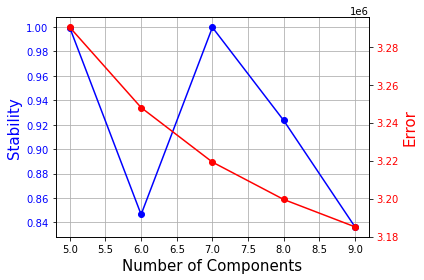

In [11]:
cnmf_obj.k_selection_plot()

### The plot was just saved to ./simulated_example_data/example_cNMF/example_cNMF.k_selection.pdf

Based on the above plot, we would be interested in investigating Ks around K=7 as a starting point as these are values where the stability has plateaued.

## We proceed to obtain the consensus matrix factorization estimates

We first look at how the results look without filtering and then set a threshold for filtering outliers based on the consensus clustergram

In [12]:
selected_K = 7

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


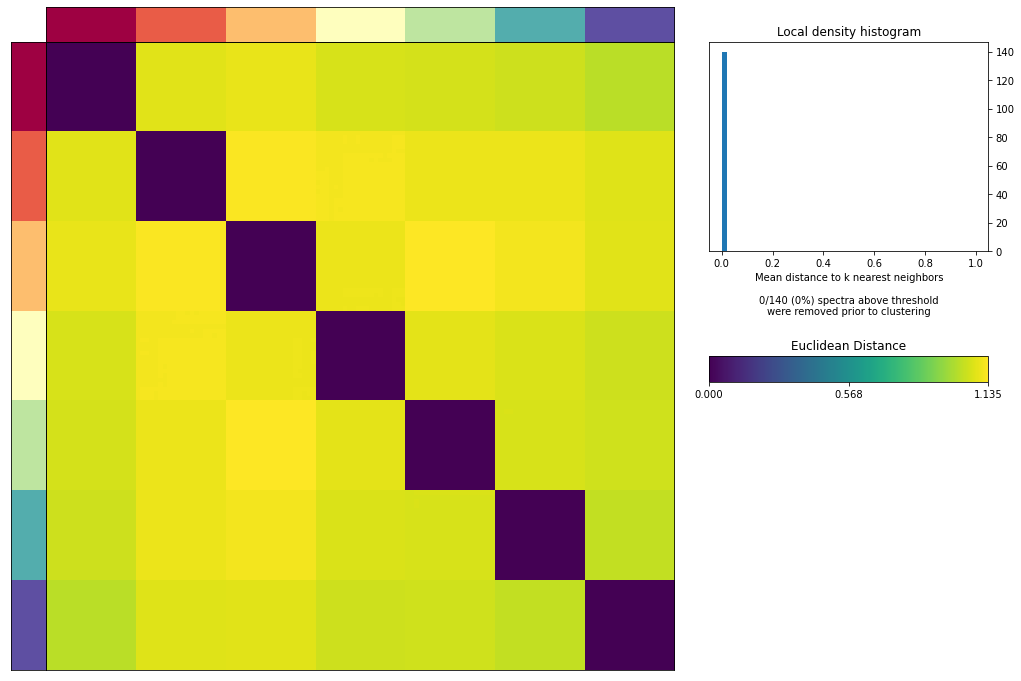

In [13]:
## Setting density_threshold to 2.0 avoids any filtering
cnmf_obj.consensus(k=selected_K, density_threshold=2.0, show_clustering=True)

This looks reasonable. We are finding 7 clusters as expected. In this case, there aren't any noisey outlier components to filter before clustering. However, in general there will be and we would filter them out by setting a threshold on the local density histogram. For example, you could set a threshold of 0.1 like below

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


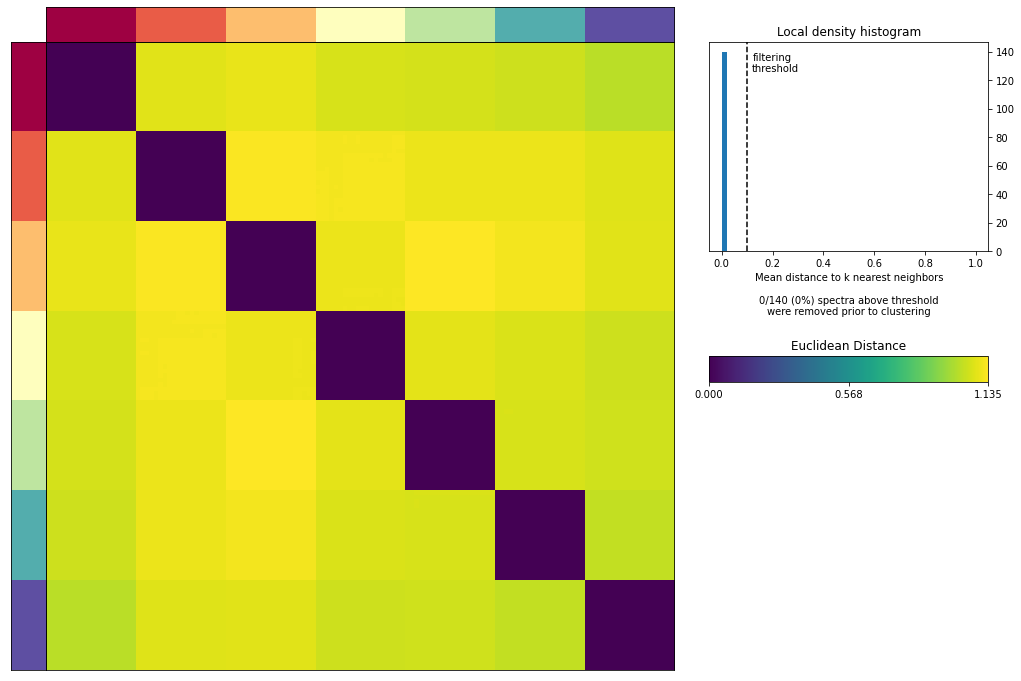

In [14]:
cnmf_obj.consensus(k=selected_K, density_threshold=0.1, show_clustering=True)

In [15]:
### The plots were just saved to example_cNMF.clustering.k_7.dt_2_0.png and example_cNMF.clustering.k_7.dt_0_1.png

In [16]:
! ls simulated_example_data/example_cNMF

cnmf_tmp
example_cNMF.clustering.k_7.dt_0_1.png
example_cNMF.clustering.k_7.dt_2_0.png
example_cNMF.gene_spectra_score.k_7.dt_0_1.txt
example_cNMF.gene_spectra_score.k_7.dt_2_0.txt
example_cNMF.gene_spectra_tpm.k_7.dt_0_1.txt
example_cNMF.gene_spectra_tpm.k_7.dt_2_0.txt
example_cNMF.k_selection.png
example_cNMF.k_selection_stats.df.npz
example_cNMF.overdispersed_genes.txt
example_cNMF.spectra.k_7.dt_0_1.consensus.txt
example_cNMF.spectra.k_7.dt_2_0.consensus.txt
example_cNMF.usages.k_7.dt_0_1.consensus.txt
example_cNMF.usages.k_7.dt_2_0.consensus.txt


### Our intended final results files are:

 - example_cNMF.gene_spectra_score.k_6.dt_0_40.txt
 - example_cNMF.gene_spectra_tpm.k_6.dt_0_40.txt
 - example_cNMF.usages.k_6.dt_0_40.consensus.txt
 
The first 2 contain the GEPs re-fit to all of the genes either in units of tpm (example_cNMF.gene_spectra_tpm.k_6.dt_0_40.txt) or in Z-score units (example_cNMF.gene_spectra_score.k_6.dt_0_40.txt). The usage matrix is (example_cNMF.usages.k_6.dt_0_40.consensus.txt)

## Now lets make a few plots to illustrate the results

### Run PCA on high-var genes TPM normalized

This step can be skipped if you want to just load the pre-generated tsne results in ./simulated_example_data/tsne.txt

## We can load normalized usages, spectra, and a list of top genes directly from our cnmf object like so

In [17]:
normalized_usage_matrix, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=selected_K, density_threshold=0.1)

## This is analogous to loading the files below with the exception that the Usage file contains per-cell usages that are not normalized to sum to 1 whereas the usage returned by load_results is normalized to sum to 1. Normalized usages are the default recommended for most users

In [18]:
usage_matrix_file = cnmf_obj.paths['consensus_usages__txt'] % (selected_K, '0_1')
usage_matrix_file

'./simulated_example_data/example_cNMF/example_cNMF.usages.k_7.dt_0_1.consensus.txt'

In [19]:
gene_scores_file = cnmf_obj.paths['gene_spectra_score__txt'] % (selected_K, '0_1')
gene_scores_file

'./simulated_example_data/example_cNMF/example_cNMF.gene_spectra_score.k_7.dt_0_1.txt'

In [20]:
gene_tpm_file = cnmf_obj.paths['gene_spectra_tpm__txt'] % (selected_K, '0_1')
gene_tpm_file

'./simulated_example_data/example_cNMF/example_cNMF.gene_spectra_tpm.k_7.dt_0_1.txt'

### We can then plot the ground truth as well as the cNMF inferences on a tSNE plot to visualize the accuracy of the inference

In [21]:
tsne_results = pd.read_csv('./simulated_example_data/tsne.txt', sep='\t', index_col=0)
tsne_results.head()

,TSNE1,TSNE2
Cell1,-26.829270,-12.981769
Cell2,5.473053,22.799021
Cell3,-22.220153,11.276251
Cell4,29.347240,3.582170
Cell5,9.972195,-1.723736


In [22]:
import palettable
from matplotlib import rcParams
from collections import Counter

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

import matplotlib as mpl
label_size = 8

core_colors = type('CoreColors', (), {})

cnames = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink', 'grey']

def to_array_col(color):
    return np.array(color)/255.

for cname,c in zip(cnames, palettable.colorbrewer.qualitative.Set1_9.colors):
    setattr(core_colors, cname, np.array(c)/255.)
    
for cname, c in zip(['blue', 'green', 'red', 'orange', 'purple'],
                    palettable.colorbrewer.qualitative.Paired_10.colors[::2]):
    setattr(core_colors, 'pale_'+cname, np.array(c)/255.)
    
core_colors.teal = to_array_col(palettable.colorbrewer.qualitative.Set2_3.colors[0])
core_colors.brown_red = to_array_col(palettable.colorbrewer.qualitative.Dark2_3.colors[1])

# core_colors.light_grey = to_array_col(palettable.colorbrewer.qualitative.Set2_8.colors[-1])
core_colors.light_grey = to_array_col(palettable.tableau.TableauLight_10.colors[7])

core_colors.royal_green = to_array_col(palettable.wesanderson.Royal1_4.colors[0])


In [23]:
celldata = pd.read_csv('./simulated_example_data/groundtruth_cellparams.txt', sep='\t', index_col=0)
celldata.head()

,group,libsize,has_program,program_usage,is_doublet,group2
Cell1,4,2623.118236,False,0.000000,False,-1
Cell2,5,1623.833614,False,0.000000,False,-1
Cell3,6,2222.490202,False,0.000000,False,-1
Cell4,1,3213.596131,True,0.262699,False,-1
Cell5,2,2396.513589,True,0.127641,False,-1


In [24]:
tsnedat = pd.merge(left=tsne_results, right=celldata, left_index=True, right_index=True)

tsnedat['extra-status'] = 'Normal'
tsnedat.loc[tsnedat['has_program'] & ~tsnedat['is_doublet'], 'extra-status'] = 'program'
tsnedat.loc[~tsnedat['has_program'] & tsnedat['is_doublet'], 'extra-status'] = 'doublet'
tsnedat.loc[ tsnedat['has_program'] & tsnedat['is_doublet'], 'extra-status'] = 'program & doublet'

In [25]:
cell_tableau10_color_id = tsnedat['group'].astype(int).values - 1
cell_tableau10_color = np.array(palettable.tableau.Tableau_10.colors[:-1])[cell_tableau10_color_id]/255.

activity_color = np.zeros((tsnedat.shape[0], 4))
activity_color[:, 3] = tsnedat['has_program'].astype(float)
doublet_color = np.array(palettable.tableau.TableauMedium_10.colors[5])/255. 

In [26]:
normal_filter = tsnedat['extra-status'] == 'Normal'
doublet_filter = tsnedat['extra-status'] == 'doublet'
activity_filter = tsnedat['extra-status'] == 'program'
activity_and_doublet_filter = tsnedat['extra-status'] == 'program & doublet'

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/tmp/ipykernel_29767/4039457763.py:32: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x[curr_filter], y[curr_filter],
/tmp/ipykernel_29767/4039457763.py:77: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter([0.54], [doub_y], c=[doublet_color],


(0.0, 1.0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Myriad Pro
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Myriad Pro


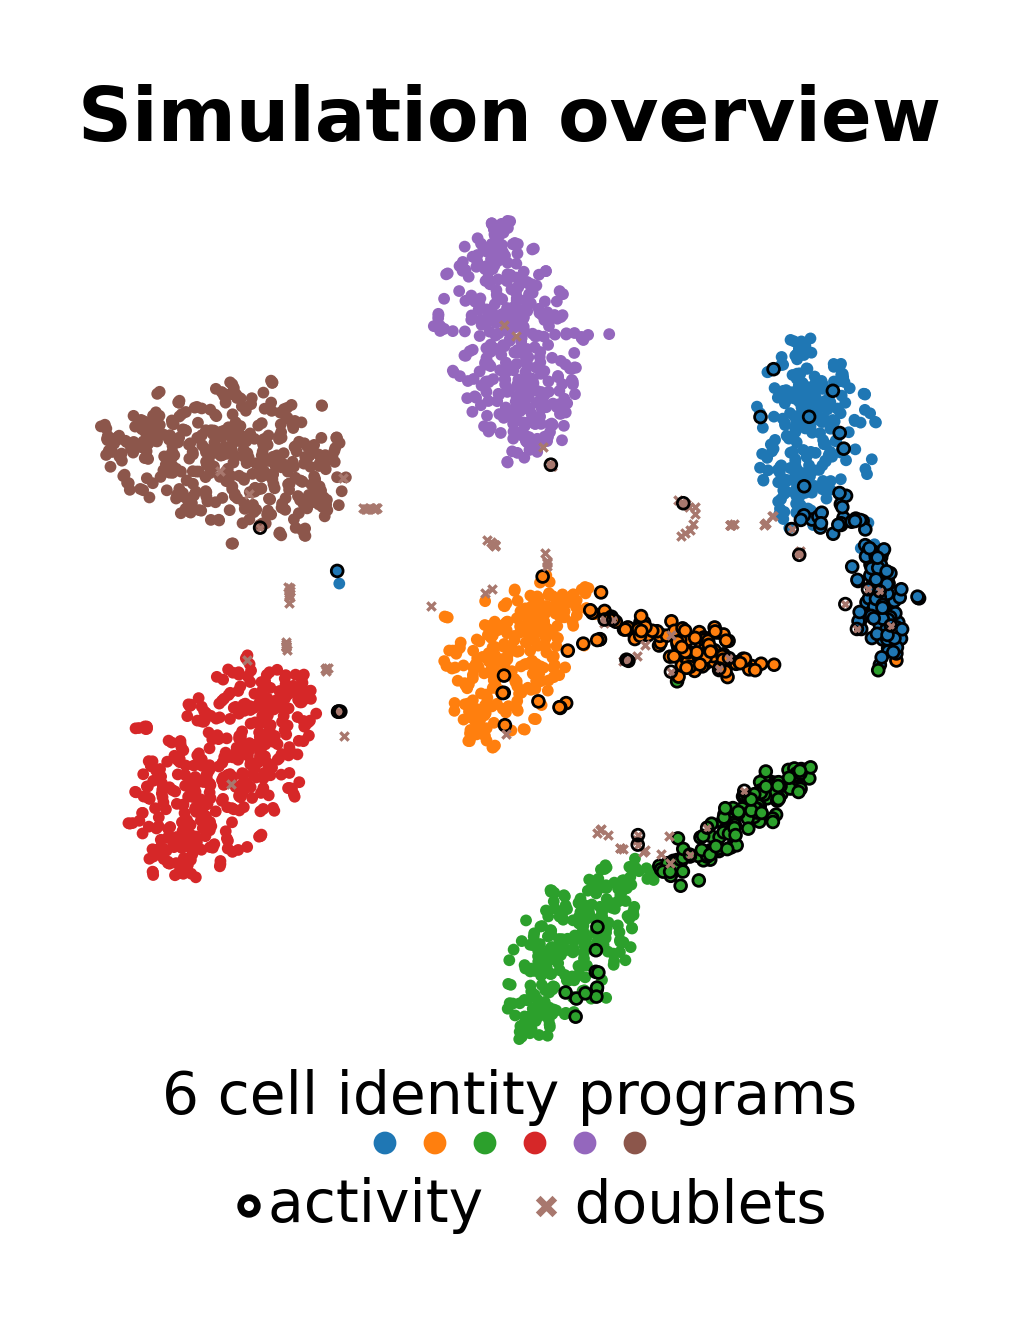

In [27]:
identityK = 6
fig = plt.figure(figsize=(1.5, 2), dpi=600)
gs = gridspec.GridSpec(3, 1, fig, 0,0,1,1,
                       hspace=0, wspace=0,
                       height_ratios=[0.2, 1.5, 0.3],
                       width_ratios=[1])

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, xticks=[], yticks=[])

x = tsnedat['TSNE1']
y = tsnedat['TSNE2']


curr_filter = normal_filter


ax.scatter(x[curr_filter], y[curr_filter],
          facecolor=cell_tableau10_color[curr_filter.values],
           edgecolor='none',
           rasterized=True, s=2)

curr_filter = activity_filter
ax.scatter(x[curr_filter], y[curr_filter],
          facecolor=cell_tableau10_color[curr_filter.values],
          edgecolor=activity_color[curr_filter.values], linewidth=0.33,
           rasterized=False, s=2)


curr_filter = doublet_filter | activity_and_doublet_filter
ax.scatter(x[curr_filter], y[curr_filter],
          c=doublet_color,
          edgecolor='none', marker='x', linewidth=0.4,
          s=1)

curr_filter = activity_and_doublet_filter
ax.scatter(x[curr_filter], y[curr_filter],
          facecolor='none',
          edgecolor=activity_color[curr_filter.values], linewidth=0.33,
           rasterized=False, s=2)


ax = fig.add_subplot(gs[0, 0],
          frameon=False, xticks=[], yticks=[], xlim=[0,1], ylim=[0,1])

ax.text(0.50, 0.5, 'Simulation overview', va='center', ha='center', fontsize=9, fontdict=dict(weight='bold'),
        clip_on=False)


ax = fig.add_subplot(gs[2, 0],
          frameon=False, xticks=[], yticks=[], xlim=[0,1], ylim=[0,1])

ax.text(0.50, 0.9, '%d cell identity programs' % identityK, va='center', ha='center', fontsize=7,
        clip_on=False)

leg_x = np.arange(identityK)/18
leg_x -= leg_x.mean()
leg_x += 0.5

ax.scatter(leg_x, np.ones(identityK)*0.65, c=np.array(palettable.tableau.Tableau_10.colors[:identityK])/255, s=3)



activity_y = 0.30
ax.text(0.33, activity_y, '  activity', verticalalignment='center', ha='center', fontsize=7,
        clip_on=False)

ax.scatter([0.21], [activity_y], 
           facecolor='none', edgecolor='k', linewidth=0.8, s=4)


doub_y = activity_y
ax.text(0.66, doub_y, '     doublets', verticalalignment='center', ha='center', fontsize=7,
        clip_on=False)

ax.scatter([0.54], [doub_y], c=[doublet_color],
           edgecolor='none', marker='x', linewidth=0.8, s=4, clip_on=False)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

In [28]:
tsne_and_usages = pd.merge(left=normalized_usage_matrix, right=tsne_results, left_index=True, right_index=True)
tsne_and_usages.head()

,1,2,3,4,5,6,7,TSNE1,TSNE2
Cell1,0.031384,0.816917,0.057581,0.019343,0.038409,0.034832,0.001533,-26.829270,-12.981769
Cell2,0.000000,0.049154,0.751432,0.021028,0.058638,0.082390,0.037358,5.473053,22.799021
Cell3,0.794945,0.013704,0.039620,0.053871,0.000804,0.076341,0.020714,-22.220153,11.276251
Cell4,0.074022,0.044766,0.001003,0.000000,0.483074,0.351682,0.045453,29.347240,3.582170
Cell5,0.010132,0.057396,0.102936,0.077047,0.080333,0.223170,0.448986,9.972195,-1.723736


In [29]:
tsne_and_usages.columns

Index([1, 2, 3, 4, 5, 6, 7, 'TSNE1', 'TSNE2'], dtype='object')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Myriad Pro
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Myriad Pro


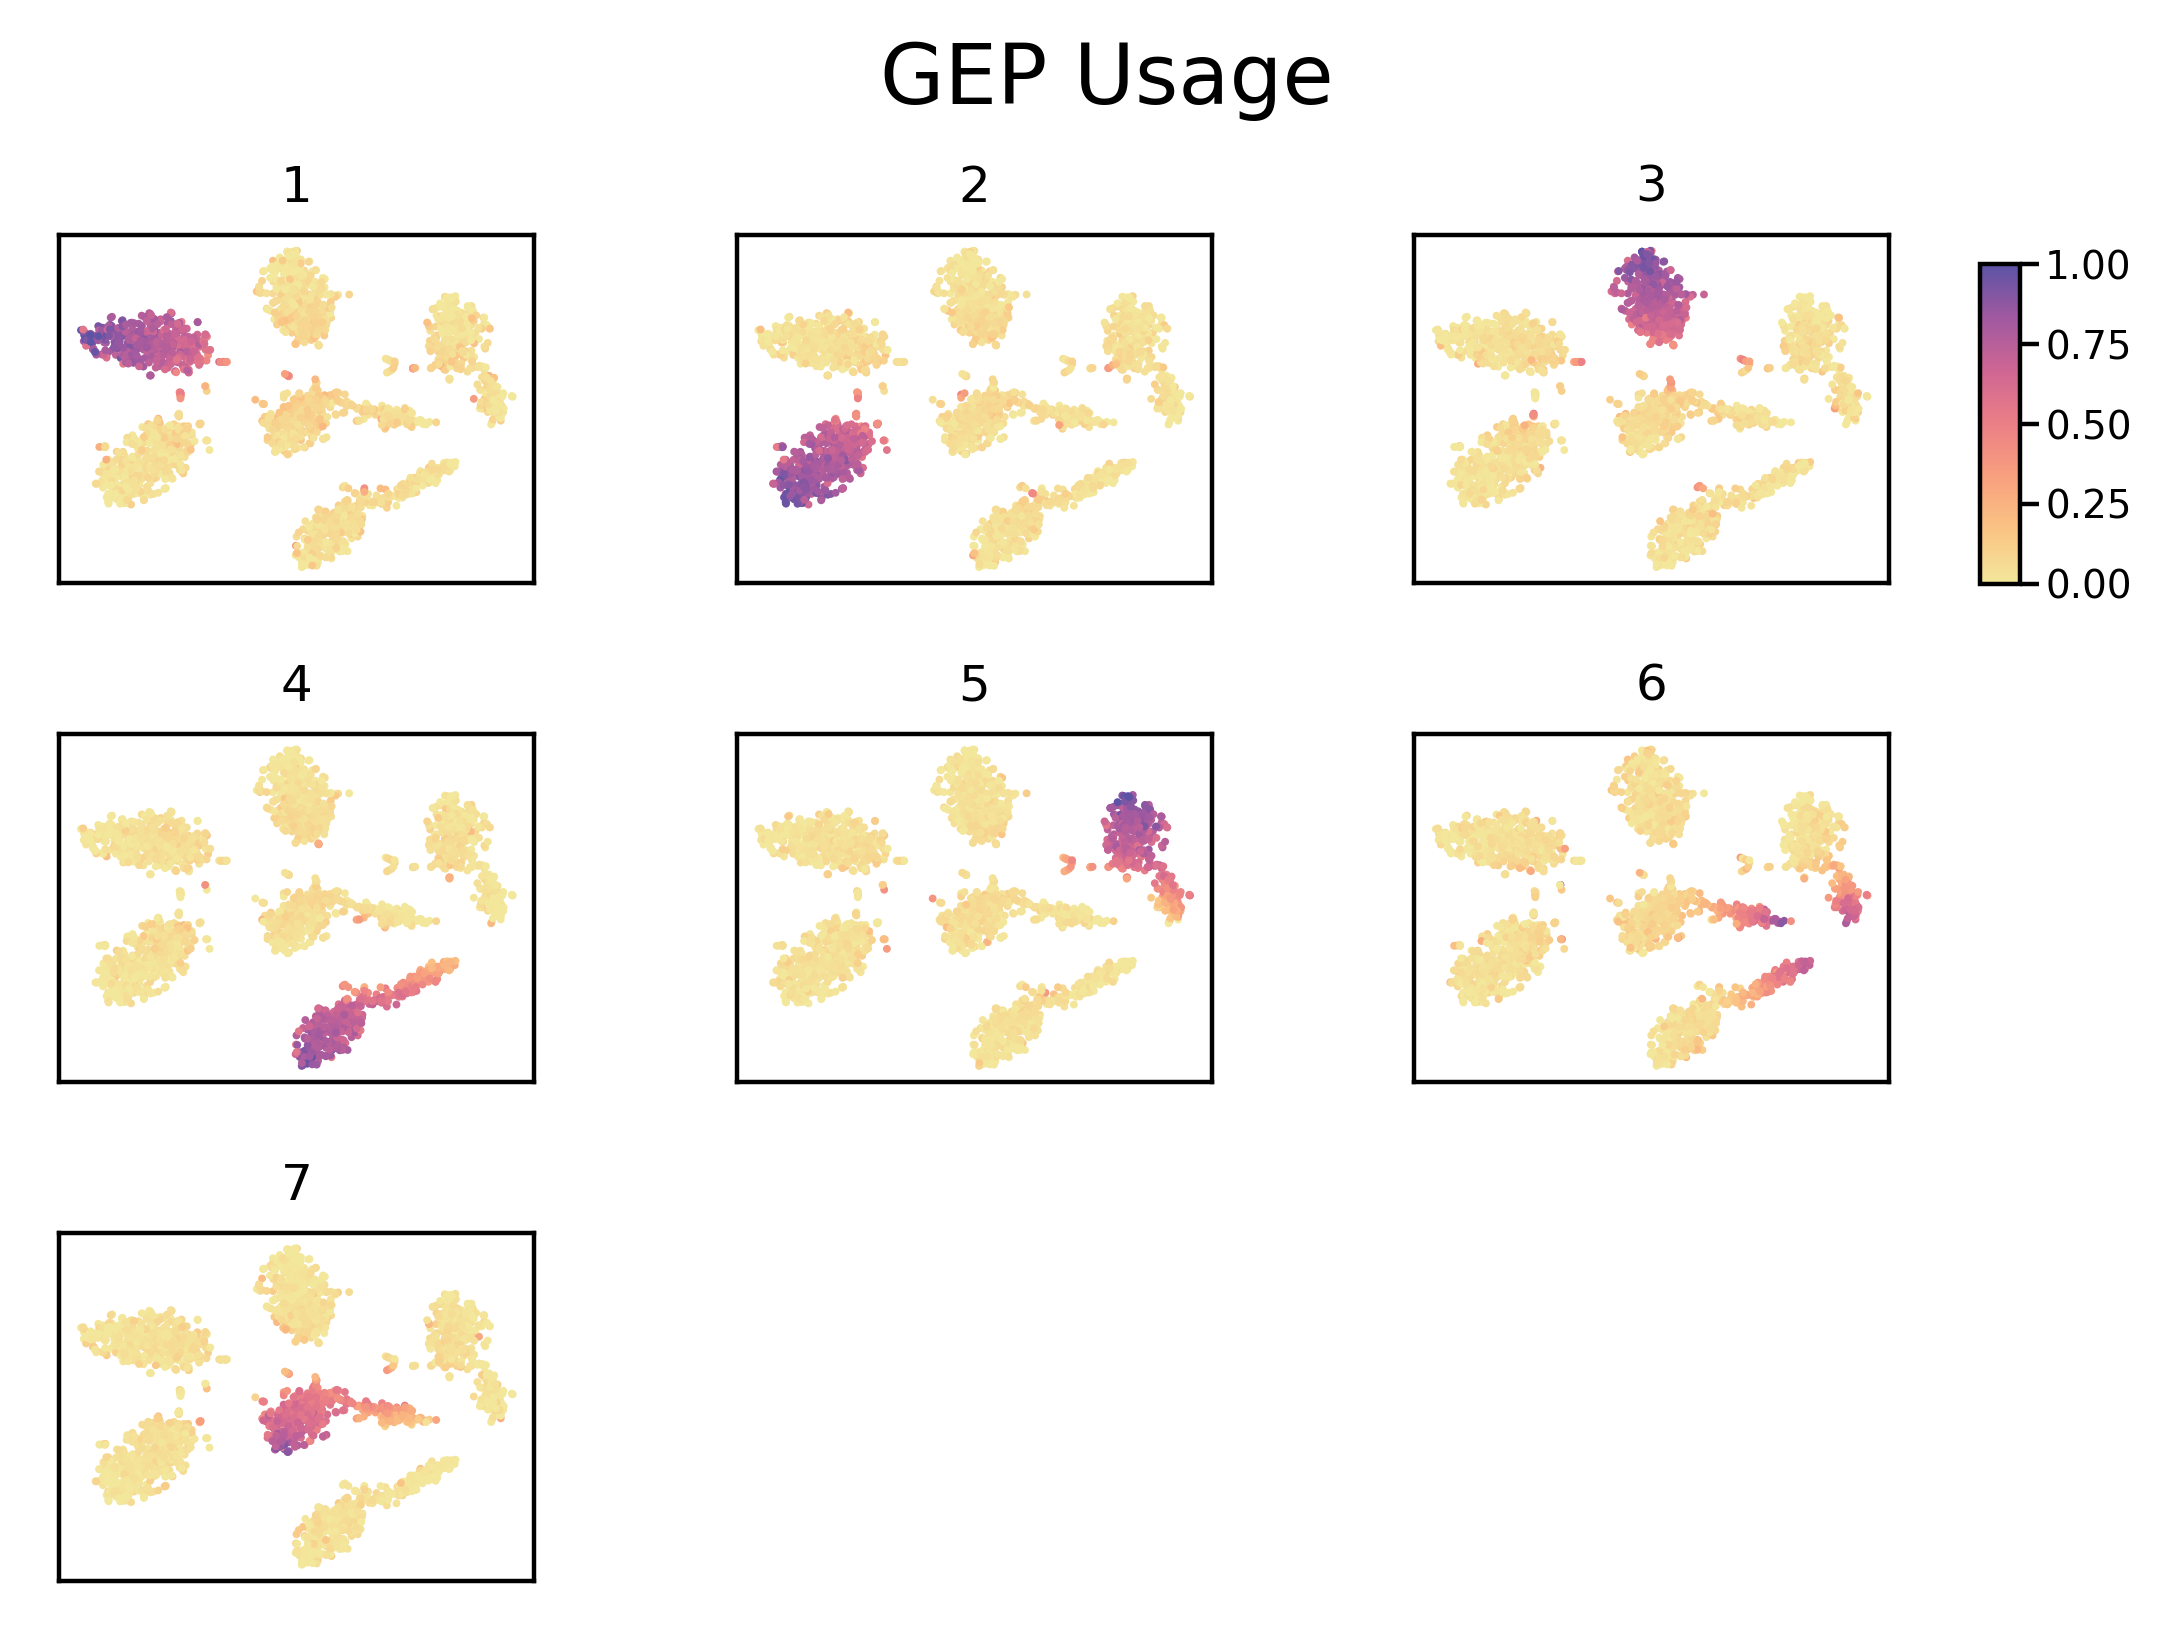

In [30]:
cmap = palettable.cartocolors.sequential.Sunset_7.get_mpl_colormap()

(fig,axes) = plt.subplots(3,3, figsize=(5,4), dpi=400)
axes = axes.ravel()
for i in range(1, selected_K+1):
    sc = axes[i-1].scatter(tsne_and_usages['TSNE1'], tsne_and_usages['TSNE2'], c=tsne_and_usages[i],
                      cmap=cmap, vmin=0, vmax=1.,
                      s=2, edgecolor='none', rasterized=True)
    axes[i-1].set_title(i)
    axes[i-1].set_xticks([])
    axes[i-1].set_yticks([])
    
    
    
plt.tight_layout()
cbarax = fig.add_axes([1,.7,.02, .2])
plt.colorbar(sc, cax=cbarax)
_ = plt.figtext(.45,1,'GEP Usage', fontsize=15)
axes[-1].remove()
axes[-2].remove()

The plot above shows which cells are expressing which programs. Program 6 is distributed over cells of multiple identity programs and therefore corresponds to the activity program. GEP 1,2 3, 4, 5, 7 correspond to distinct identity programs

## We might also want to investigate which genes are driving which programs. The top_genes ranks the genes most associated with each GEP (based on the spectra_scores)

In [31]:
topgenes.head(20)

,1,2,3,4,5,6,7
0,Gene6757,Gene2342,Gene8378,Gene9445,Gene6144,Gene9938,Gene8555
1,Gene72,Gene2634,Gene7654,Gene5098,Gene610,Gene9639,Gene6335
2,Gene1643,Gene5050,Gene263,Gene8394,Gene8402,Gene9730,Gene1448
3,Gene7907,Gene8933,Gene8614,Gene6691,Gene7378,Gene9953,Gene3488
4,Gene1091,Gene6244,Gene6950,Gene1053,Gene5024,Gene9682,Gene6732
5,Gene5983,Gene2086,Gene7600,Gene47,Gene5987,Gene9636,Gene2044
6,Gene2551,Gene4462,Gene944,Gene2582,Gene9540,Gene9683,Gene930
7,Gene7361,Gene498,Gene4364,Gene4666,Gene8511,Gene9767,Gene2806
8,Gene5686,Gene8960,Gene324,Gene6395,Gene3287,Gene9699,Gene3052
9,Gene6936,Gene8507,Gene1393,Gene4151,Gene7406,Gene9873,Gene2556
